# 0. Setup

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-8e58684c-33e7-69fa-082f-8fae0e4c5077)
GPU 1: NVIDIA GeForce RTX 4090 (UUID: GPU-82fefc93-382a-0b5a-fec6-f3b57cd9185f)


In [2]:
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import csv
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from misc.helpers import find_model_weights, calculate_label_distributions, prev_img, prev_img_gray, trans_norm2tensor, find_csv_files, get_image_paths_from_csv, get_image_paths_from_dir, get_image_filenames_by_label, create_vit_model
from misc.visualization import *
from scipy.stats import entropy
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from model.vit_for_small_dataset import ViT
from utils.imageQualityDataset import ImageQualityDataset
from utils.imageAttentionGlobalAvgDataset import ImageAttentionGlobalAvgDataset



In [3]:
import torch
import numpy as np

def calculate_average_attention_in_crop(attention_map, crop_bbox, patch_size):
    """
    Calculate the average attention within a specified crop region.

    Args:
    - attention_map (torch.Tensor or np.ndarray): Attention map of shape (H, W).
    - crop_bbox (tuple): Bounding box coordinates (left, top, right, bottom) in pixel space.
    - patch_size (int): Size of each patch in pixels.

    Returns:
    - float: Average attention within the cropped region.
    """

    # Convert the bounding box from pixel space to patch space
    left, top, right, bottom = [coord // patch_size for coord in crop_bbox]
    print("Left, Top, Right, Bottom", left, top, right, bottom)
    # print(left, top, right, bottom)
    # Ensure that the attention_map is in numpy format for easier indexing
    if isinstance(attention_map, torch.Tensor):
        attention_map = attention_map.cpu().numpy()

    # Extract the attention map within the crop region
    crop_attention = attention_map[top:bottom, left:right]

    # Calculate the average attention in the cropped region
    avg_attention = np.mean(crop_attention)
    
    return avg_attention

def calculate_sum_attention_in_crop(attention_map, crop_bbox, patch_size):
    """
    Calculate the sum of attention within a specified crop region.

    Args:
    - attention_map (torch.Tensor or np.ndarray): Attention map of shape (H, W).
    - crop_bbox (tuple): Bounding box coordinates (left, top, right, bottom) in pixel space.
    - patch_size (int): Size of each patch in pixels.

    Returns:
    - float: Sum of attention within the cropped region.
    """

    # Convert the bounding box from pixel space to patch space
    left, top, right, bottom = [coord for coord in crop_bbox]
    # print("Left, Top, Right, Bottom", left, top, right, bottom)
    # print(left, top, right, bottom)

    # Ensure that the attention_map is in numpy format for easier indexing
    if isinstance(attention_map, torch.Tensor):
        attention_map = attention_map.cpu().numpy()

    # Extract the attention map within the crop region
    crop_attention = attention_map[top:bottom, left:right]
    # print(f"Crop Atenntion shape: {crop_attention.shape}")

    # print(f"Crop Attention: {crop_attention}")
    # print(f"Crop Attention Sum: {crop_attention.sum()}")
    # print(f"Crop Attention Mean: {crop_attention.mean()}")




    # Calculate the sum of attention in the cropped region
    sum_attention = np.sum(crop_attention)

    return sum_attention


In [4]:
def preprocess_img_gray(img: Image.Image) -> Image.Image:
    """
    Process the image for previewing purposes with grayscale and contrast adjustment.

    This function applies transformations to resize and center crop the input image to a specified size.
    It then converts the image to grayscale and enhances the contrast by scaling the luminance values.
    
    Parameters:
    img (PIL.Image): The input image.

    Returns:
    img_bw_contrast_rgb (PIL.Image): The processed image with enhanced contrast in RGB format.
    """

    # Convert the image to grayscale
    img_bw = img.convert('L')

    # Convert grayscale image to YCbCr color space
    img_ycbcr = img_bw.convert('YCbCr')
    y, cb, cr = img_ycbcr.split()
    # Convert Y channel to NumPy arrays
    y_array = np.array(y)

    # Perform contrast adjustment on the Y component
    y_array = np.clip(y_array * 2.0, 0, 255).astype(np.uint8)

    # Merge the adjusted Y, Cb, Cr components back into an image
    img_bw_contrast = Image.merge('YCbCr', (Image.fromarray(y_array), cb, cr))

    # Convert the image back to RGB for display
    img_bw_contrast_rgb = img_bw_contrast.convert('RGB')
    
    return img_bw_contrast_rgb

# 1. Build Model

In [5]:
image_size=256
patch_size=16
num_classes=5
depth = 6

In [6]:
model = create_vit_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Define the normalization parameters (mean and std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformation including normalization
img2tensor_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Beginn Analysis

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFilter, ImageOps
import random
import numpy as np
import os
import csv
from io import BytesIO

# 1. Define a custom dataset class
class TestDatasetWithTransformations(Dataset):
    def __init__(self, image_paths, transform=None, num_transformations=4, crop_size=96):
        """
        Args:
            image_paths (list): List of paths to the test images.
            transform (callable, optional): A function/transform to apply to each image.
            num_transformations (int): Number of transformations per image.
        """
        self.image_paths = image_paths
        self.crop_size = crop_size
        self.transform = transform
        self.num_transformations = num_transformations
        self.transforms = [
            self.occlusion_transform,
            self.grayscale_transform,
            self.compression_transform,
            self.blur_transform
        ]
        print(f"Dataset initialized with {len(image_paths)} images.")  # Print message

    def __len__(self):
        """Returns the number of original images."""
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """Fetches the original image and its transformed versions."""
        # Load the original image
        original_image = Image.open(self.image_paths[idx]).convert('RGB')
        
        # Preprocess the original image (resize, crop, etc.)
        original_image_processed = self.preprocess(original_image)
        
        # Apply all transformations to the original image
        transformed_images = []
        for transform_fn in self.transforms:
            transformed_image = transform_fn(original_image_processed.copy())  # Apply transformation
            if self.transform:
                transformed_image = self.transform(transformed_image)  # Apply additional transformations if any
            transformed_images.append(transformed_image)
        
        # Ensure the original image is also transformed into a tensor
        if self.transform:
            original_image_processed = self.transform(original_image_processed)


        return original_image_processed, torch.stack(transformed_images)
    
    def preprocess(self, image):
        """Preprocesses the image for the model."""
        preprocess = transforms.Compose([
            transforms.Resize(256),  # Resize to the model input size (e.g., 224x224 for ViT)
            transforms.CenterCrop(256),  # Resize to the model input size (e.g., 224x224 for ViT)
        ])
        return preprocess(image)

    def get_center(self, image):
        """Returns the center coordinates of the image. (left, top, right, bottom)"""
        w, h = image.size
        left = (w - self.crop_size) // 2
        top = (h - self.crop_size) // 2
        right = (w + self.crop_size) // 2
        bottom = (h + self.crop_size) // 2
        return left, top, right, bottom

    def occlusion_transform(self, image):
        """Randomly occludes the center of the image."""
        left, top, right, bottom = self.get_center(image)
        image.paste((0, 0, 0), (left, top, right, bottom))  # Black square occlusion
        return image
    
    def grayscale_transform(self, image):
        """Converts the image to grayscale."""
        left, top, right, bottom = self.get_center(image)
        patch = image.crop((left, top, right, bottom))  # Crop the center patch
        patch = ImageOps.grayscale(patch).convert("RGB")  # Convert to grayscale
        image.paste(patch, (left, top, right, bottom))
        return image
    
    def compression_transform(self, image):
        """Compress a part of the image based on crop position."""
        left, top, right, bottom = self.get_center(image)
        patch = image.crop((left, top, right, bottom))
        buffer = BytesIO()
        patch.save(buffer, format="JPEG", quality=0)
        patch = Image.open(buffer)
        image.paste(patch, (left, top, right, bottom))
        return image
    
    def blur_transform(self, image):
        """Applies a Gaussian blur to the image."""
        left, top, right, bottom = self.get_center(image)
        patch = image.crop((left, top, right, bottom))
        patch = patch.filter(ImageFilter.GaussianBlur(radius=6))  # Apply blur
        image.paste(patch, (left, top, right, bottom))
        return image

# 2. Define the transformations (for resizing, normalizing, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Example: Read CSV and filter the image paths
image_dir = 'assets/Test/DSX'
csv_file = 'assets/Test/Obs0.csv'

image_paths = []

with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        image_filename = row[0]
        vote = row[1]
        if int(vote) == 5:
            image_path = os.path.join(image_dir, image_filename)
            image_paths.append(image_path)

print(f"Filtered {len(image_paths)} images with vote == 5.")  # Print message

# 4. Create the custom dataset
dataset = TestDatasetWithTransformations(image_paths, transform=transform, num_transformations=4)
print(f"Dataset contains {len(dataset)} original images.")  # Print message


Filtered 60 images with vote == 5.
Dataset initialized with 60 images.
Dataset contains 60 original images.


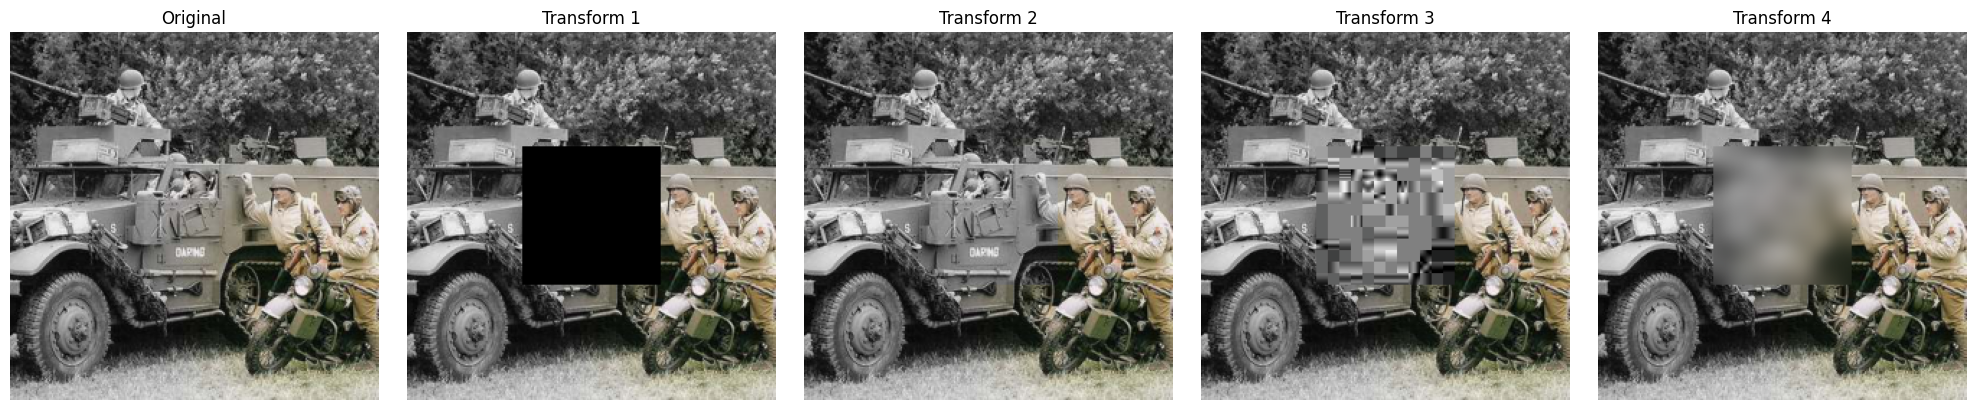

In [15]:
# Visualize the output for a specific image and its transformations
import matplotlib.pyplot as plt

# Randomly select an image
image_idx = random.randint(0, len(dataset)-1)
original_image, transformed_images = dataset[image_idx]

# Convert the original image tensor to a NumPy array for visualization
original_image = original_image.permute(1, 2, 0).numpy()
# Denormalize the image
original_image = original_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
original_image = np.clip(original_image, 0, 1)

# Plot the original image and its transformations
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes[0].imshow(original_image)
axes[0].set_title('Original')
axes[0].axis('off')

# Plot each transformed image
for i, transformed_image in enumerate(transformed_images):
    transformed_image = transformed_image.permute(1, 2, 0).numpy()
    # Denormalize the image
    transformed_image = transformed_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    transformed_image = np.clip(transformed_image, 0, 1)

    axes[i+1].imshow(transformed_image)
    axes[i+1].set_title(f'Transform {i+1}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# 5. Create a DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
print("DataLoader created.")  # Print message

# Erstellen einer Liste, die die Daten für den DataFrame speichert
attention_data = []

# 6. Evaluate with your ViT models (assuming you have 4 trained models)
weights_dir = "results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL"
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1,6)]
print(f"Weight files: {weight_files}")  # Print message

for weight_file in weight_files:
    print(f"Loading model: {weight_file}")  # Print message
    model = create_vit_model(weights_path=weight_file)
    model = Recorder(model).to(device)
    # model.eval()  # Set models to evaluation mode
    with torch.no_grad():
        # Iterate over the DataLoader and evaluate each transformed image
        for batch_idx, (original_images, transformed_images_batch) in enumerate(dataloader):

            w_featmap = original_images.shape[-2] // patch_size
            h_featmap = original_images.shape[-1] // patch_size
            print(f"Evaluating batch {batch_idx + 1}/{len(dataloader)}.")  # Print message
            outputs, attentions = model(original_images.to(device))
            print("outputs shape:", outputs.shape)  # batch, num_classes

            print("attentions shape:", attentions.shape)  # batch, depth, num_heads, num_patches + 1, num_patches + 1

            preds = torch.argmax(outputs, dim=1)  # Predicted labels for the batch
            print(f"Predicted labels: {preds}")  # Print message

            nh = attentions.shape[2]  # Number of heads
            nl = attentions.shape[1]  # Number of layers

            # Initialize tensor for attention maps
            batch_size = original_images.size(0)
            atts = torch.zeros(batch_size, nl, nh, attentions.shape[-1] - 1, attentions.shape[-1] - 1, device=device)

            # Process attentions layer-by-layer and head-by-head
            for i in range(nl):
                # Extract and reshape attention maps for the current layer
                # attentions[:, i, :, 0, 1:] is the [CLS] token to patches attentions
                att = attentions[:, i, :, 0, 1:].reshape(nh, -1)
                print("attentions", att.shape) 
                att = att.reshape(batch_size, nh, w_featmap, h_featmap)
                print("attentions", att.shape) 
                att = nn.functional.interpolate(att, scale_factor=patch_size, mode="bilinear")[0]
                print("attentions", att.shape) 
                atts[:, i, :, :, :] = att  # Assign to the result tensor

            # Now atts contains the attention maps for all images in the batch, all layers, and all heads. (batch_size, num_layers, num_heads, height, width)
            # Keep only attentions from a specific layer, if needed
            layer_idx = -1  # Change to desired layer index
            selected_atts = atts[:, layer_idx, :, :, :]  # Shape: (batch_size, nh, H, W)
            print(f"Selected layer ({layer_idx}) attention maps shape: {selected_atts.shape}")

            mean_head_atts = torch.mean(selected_atts, dim=1)  # Average over heads
            print(f"Mean head attention maps shape: {mean_head_atts.shape}") # Example: (batch_size, H, W)


            # Min/Max Normaliaztion for each image in batch
            batch_min = mean_head_atts.view(mean_head_atts.size(0), -1).min(dim=1)[0].view(-1, 1, 1)
            batch_max = mean_head_atts.view(mean_head_atts.size(0), -1).max(dim=1)[0].view(-1, 1, 1)

            # Normalize: (x - min) / (max - min)
            # normalized_atts = (mean_head_atts - batch_min) / (batch_max - batch_min + 1e-6)  # Adding epsilon to avoid division by zero
            normalized_atts = (mean_head_atts - batch_min) / (batch_max - batch_min)  # Adding epsilon to avoid division by zero
            print(f"Normalized attention maps shape: {normalized_atts.shape}")  # Shape: (batch_size, H, W)

            h, w = normalized_atts.shape[1], normalized_atts.shape[2]  # Height and width of the attention map
            crop_size = 96  # Desired crop size
            left = (w - crop_size) // 2
            top = (h - crop_size) // 2
            right = (w + crop_size) // 2
            bottom = (h + crop_size) // 2

            cropped_atts = mean_head_atts[:, top:bottom, left:right]  # Remove the class token dimension

            print("cropped atts", cropped_atts.shape)  # Shape: (batch_size, crop_size, crop_size)

            avg_cropped_atts = torch.mean(cropped_atts)  # Average over the cropped region
            print(f"Average cropped attention maps shape: {avg_cropped_atts.cpu().numpy()}")  # Shape: (batch_size, )

            attention_data.append({"Transformation": "original", "Attention Sum": avg_cropped_atts.item(), "Weight File": weight_file})

            # Speichern der Daten für die transformierten Bilder
            for transform_idx, transformed_images in enumerate(transformed_images_batch):
                # Berechnung der Attention für jedes transformierte Bild
                # (Die Berechnung der Attention Maps für transformierte Bilder erfolgt wie oben)
                # Hier als Beispiel den gleichen Ansatz verwenden
                transformed_image = transformed_images.to(device)
                outputs, attentions = model(transformed_image)

                nh = attentions.shape[2]
                nl = attentions.shape[1]
                atts = torch.zeros(batch_size, nl, nh, attentions.shape[-1] - 1, attentions.shape[-1] - 1, device=device)

                for i in range(nl):
                    att = attentions[:, i, :, 0, 1:].reshape(nh, -1)
                    print("attentions trans", att.shape) 
                    att = att.reshape(batch_size, nh, w_featmap, h_featmap)
                    print("attentions trans", att.shape) 
                    att = nn.functional.interpolate(att, scale_factor=patch_size, mode="bilinear")[0]
                    atts[:, i, :, :, :] = att

                selected_atts = atts[:, layer_idx, :, :, :]
                mean_head_atts = torch.mean(selected_atts, dim=1)

                batch_min = mean_head_atts.view(mean_head_atts.size(0), -1).min(dim=1)[0].view(-1, 1, 1)
                batch_max = mean_head_atts.view(mean_head_atts.size(0), -1).max(dim=1)[0].view(-1, 1, 1)
                normalized_atts = (mean_head_atts - batch_min) / (batch_max - batch_min)

                cropped_atts = mean_head_atts[:, top:bottom, left:right]
                avg_cropped_atts = torch.mean(cropped_atts)

                attention_data.append({"Transformation": f"transformed_{transform_idx + 1}", "Attention Sum": avg_cropped_atts.item(), "Weight File": weight_file})

    model.clear()  # Clear the model to free up memory
    # torch.cuda.empty_cache()  # Clear the GPU cache

# Erstellen eines DataFrames mit den gesammelten Daten
df_attention_data = pd.DataFrame(attention_data)
print(df_attention_data)

# Optional: Speichern des DataFrames in einer CSV-Datei
df_attention_data.to_csv("attention_data.csv", index=False)            


DataLoader created.
Weight files: ['results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL\\AIO1.pth', 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL\\AIO2.pth', 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL\\AIO3.pth', 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL\\AIO4.pth', 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL\\AIO5.pth']
Loading model: results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL\AIO1.pth
Evaluating batch 1/4.
outputs shape: torch.Size([16, 5])
attentions shape: torch.Size([16, 6, 16, 257, 257])
Predicted labels: tensor([4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 2, 3, 4, 3], device='cuda:0')
attentions torch.Size([16, 4096])
attentions torch.Size([16, 16, 16, 16])
attentions torch.Size([16, 256, 256])
attentions torch.Size([16, 4096])
attentions torch.Size([16, 16, 16, 16])
attentions torch.Size([16, 256, 256])
attentions torch.Size([16, 4096])
attentions torch.Size([16, 16, 16, 16])
attentions torch.Size([16, 256, 256])
attentions torch.Size([16, 4096])

RuntimeError: shape '[16, 16, 16, 16]' is invalid for input of size 16384

In [114]:
weights_dir = "results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL"
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1,6)]
weight_file = weight_files[0]
print(weight_file)

output_dir = f"results/Attention_maps/compare_transformations/center"
# create output_dir if not exists
os.makedirs(output_dir, exist_ok=True)
layer_idx = 5


results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL\AIO1.pth


In [117]:
fontsize=30

In [ ]:
# Define the dataloader for the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

attention_data_avg = []
attention_data_sum = []
# Iterate over the dataloader
for i, weight_file in enumerate(weight_files):
    # Displaying the attention maps for each weight_file in the next row
    model = create_vit_model(weights_path=weight_file)
    model.eval()
    model.to(device)
    weight_name = os.path.basename(weight_file).split('.')[0]
    
    for batch_idx, (image_idx, org_img, trans_imgs) in enumerate(dataloader):


        # Calculate attention maps for the original and transformed images
        img_pre_org = trans_norm2tensor(org_img, image_size, transformation_function=None)
        _, attention_org = get_attention_maps(model, img_pre_org, patch_size, device)
        # get attention in layer_idx layer
        layer_attention_org = attention_org[layer_idx]
        # normalize the mean head attention (mean of all heads, axis=0)
        layer_mean_org = normalize_attention_maps(np.mean(layer_attention_org, axis=0))
        # print(f"Layer Mean Org Shape: {layer_mean_org.shape}")
        # print(f"Layer Mean Org: {layer_mean_org}")
        # print(f"Layer Mean Org Sum: {layer_mean_org.sum()}")
        # print min max value of layer_mean_org
        # print(f"Layer Mean Org Min: {layer_mean_org.min()}")
        # print(f"Layer Mean Org Max: {layer_mean_org.max()}")

        # Calculate attention maps for the transformed images
        imgs_pre_trans = [trans_norm2tensor(img, image_size, transformation_function=None) for img in trans_imgs]
        atts_trans = [get_attention_maps(model, img_pre_trans, patch_size, device)[1] for img_pre_trans in imgs_pre_trans]
        layer_atts_trans = [att[layer_idx] for att in atts_trans]
        layer_mean_trans = [normalize_attention_maps(np.mean(layer_att, axis=0)) for layer_att in layer_atts_trans]

        crop_bbox = transformations.get_random_bbox(org_img, crop_size=crop_size, crop_pos=crop_position)
        # print(f"Crop BBox: {crop_bbox}")

        # Calculate the sum of attention within the cropped region
        sum_attention_org = calculate_sum_attention_in_crop(
            attention_map=layer_mean_org, 
            crop_bbox=crop_bbox, 
            patch_size=patch_size)
        
        # Store the data in the dictionary
        attention_data_sum.append({"Transformation": f"original", "Attention Sum": sum_attention_org, "Weight File": weight_name})
        # print(f"Original Attention: {sum_attention_org}")
        # Store average attention for each transformation level and weight
        attention_data_sum.append({"Transformation": f"original", "Attention Sum": sum_attention_org, "Weight File": weight_file})
        for j, (lmt, img, (transform_func,_)) in enumerate(zip(layer_mean_trans, trans_imgs, dataset.transforms_per_image)):

            # Calculate the sum of attention within the cropped region
            sum_attention = calculate_sum_attention_in_crop(
                attention_map=lmt, 
                crop_bbox=crop_bbox, 
                patch_size=patch_size)

            # Store the data in the dictionary
            attention_data_sum.append({"Transformation": f"{transform_func.__name__.split('_')[1]}", "Attention Sum": sum_attention, "Weight File": weight_name})
            # print(f"Transfromed Attention ({transform_func.__name__.split('_')[1]}): {sum_attention}")


            attention_data_sum.append({"Transformation": f"{transform_func.__name__.split('_')[1]}", "Attention Sum": sum_attention, "Weight File": weight_file})
            # Format the transformation name (capitalize first letter)
            transform_name = transform_func.__name__.split("_")[1]
            transform_name = transform_name[0].upper() + transform_name[1:]


        # Clear the model from memory
        del model

# Create a DataFrame for boxplot
attention_df_sum = pd.DataFrame(attention_data_sum)
attention_df_avg = pd.DataFrame(attention_data_avg)


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
import pandas as pd
import os

# Convert attention_data_avg to a DataFrame
attention_df_avg = pd.DataFrame(attention_data_sum)

# Define the order of the transformations
transformations_order = ["original", "occlusion", "compression", "grayscale", "blur"]

# Ensure the 'Transformation' column is of a category type with the defined order
attention_df_avg['Transformation'] = pd.Categorical(attention_df_avg['Transformation'], categories=transformations_order, ordered=True)

# Sort the DataFrame by 'Transformation'
attention_df_avg.sort_values('Transformation', inplace=True)

# Create a pivot table for Average Attention
pivot_table_avg = pd.pivot_table(
    attention_df_avg,
    values="Attention Sum",    # Values to summarize
    index="Transformation",    # Rows
    columns="Weight File",     # Columns
    aggfunc="mean"             # Aggregation function
)

# Optionally format the table (e.g., rounding values for readability)
pivot_table_avg = pivot_table_avg.round(3)

# Save the pivot table as a CSV for inspection
pivot_table_avg.to_csv(os.path.join(output_dir, "average_attention_summary.csv"))

# Print the table to verify
print(pivot_table_avg)


In [ ]:
import pandas as pd
import os

# Convert attention_data_avg to a DataFrame
attention_df_avg = pd.DataFrame(attention_data_sum)

# Define the order of the transformations
transformations_order = ["original", "occlusion", "compression", "grayscale", "blur"]

# Ensure the 'Transformation' column is of a category type with the defined order
attention_df_avg['Transformation'] = pd.Categorical(attention_df_avg['Transformation'], categories=transformations_order, ordered=True)

# Sort the DataFrame by 'Transformation'
attention_df_avg.sort_values('Transformation', inplace=True)

# Create a pivot table for Average Attention
pivot_table_avg = pd.pivot_table(
    attention_df_avg,
    values="Attention Sum",    # Values to summarize
    index="Transformation",    # Rows
    columns="Weight File",     # Columns
    aggfunc="mean"             # Aggregation function  

)

# Round the original pivot table values to 2 decimal places
pivot_table_avg = pivot_table_avg.round(2)
# Save the original pivot table
pivot_table_avg.to_csv(os.path.join(output_dir, "average_attention_summary.csv"))

# Calculate percentage change relative to the "original" row
original_values = pivot_table_avg.loc["original"].round(2)

# Calculate percentage change
percentage_change_table = (pivot_table_avg - original_values) / original_values * 100

# Format the table with original values and percentage changes
formatted_table = pivot_table_avg.copy()

# Iterate over transformations and modify the table
for transformation in transformations_order:
    if transformation == "original":
        # Round the original values to 2 decimal places
        formatted_table.loc[transformation] = formatted_table.loc[transformation].round(2)
    else:
        # Add percentage change values and append '%'
        formatted_table.loc[transformation] = (
            percentage_change_table.loc[transformation]
            .round(2)  # Round percentage change
            .astype(str)  # Convert to string
            + " %"  # Append '%'
        )

# Save the formatted table to a CSV
formatted_table.to_csv(os.path.join(output_dir, "formatted_percentage_change_attention_summary.csv"))

# Print the formatted table for verification
print("Formatted Table with Original Values and Percentage Changes:")
print(formatted_table)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a directory to save the boxplots if it doesn't exist
boxplot_dir = os.path.join(output_dir, "boxplots")
os.makedirs(boxplot_dir, exist_ok=True)

# Calculate the global y-axis limits for consistent scale
y_min = attention_df_avg["Attention Sum"].min() - 1000
y_max = attention_df_avg["Attention Sum"].max() + 1000

# Iterate over each "Weight File" and create a boxplot for each
for weight_file in attention_df_avg['Weight File'].unique():
    # Filter the DataFrame for the current weight file
    filtered_df = attention_df_avg[attention_df_avg['Weight File'] == weight_file]
    
    # Create a boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=filtered_df,
        x="Transformation",
        y="Attention Sum",
        order=transformations_order,  # Ensures the correct order of the x-axis
        palette="Set2"
    )
    
    # Set consistent y-axis limits
    plt.ylim(y_min, y_max)
    
    # Add titles and labels
    plt.title(f"Attention Sum Distribution for {weight_file}", fontsize=14)
    plt.xlabel("Transformation", fontsize=12)
    plt.ylabel("Attention Sum", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    
    # Save the plot
    boxplot_path = os.path.join(boxplot_dir, f"boxplot_{weight_file.replace(' ', '_')}.png")
    plt.tight_layout()
    plt.savefig(boxplot_path)
    plt.close()  # Close the figure to free up memory

    print(f"Saved boxplot for {weight_file} at {boxplot_path}")


In [ ]:
import pandas as pd
import os

# Convert attention_data_avg to a DataFrame
attention_df_avg = pd.DataFrame(attention_data_sum)

# Define the order of the transformations
transformations_order = ["original", "occlusion", "compression", "grayscale", "blur"]

# Ensure the 'Transformation' column is of a category type with the defined order
attention_df_avg['Transformation'] = pd.Categorical(attention_df_avg['Transformation'], categories=transformations_order, ordered=True)

# Sort the DataFrame by 'Transformation'
attention_df_avg.sort_values('Transformation', inplace=True)

# Separate original and transformed rows
original_attention = attention_df_avg[attention_df_avg['Transformation'] == 'original']
transformed_attention = attention_df_avg[attention_df_avg['Transformation'] != 'original']

# Function to compute mean ± std
def mean_std_formatter(x):
    mean = x.mean()
    std = x.std()
    return f"{mean:.2f} (+/- {std:.2f})"

# Create a pivot table for transformed rows with mean ± std
pivot_table_transformed = transformed_attention.pivot_table(
    values="Attention Sum",
    index="Transformation",
    columns="Weight File",
    aggfunc=lambda x: mean_std_formatter(x)
)

# Create a pivot table for original rows (mean only, no std)
pivot_table_original = original_attention.pivot_table(
    values="Attention Sum",
    index="Transformation",
    columns="Weight File",
    aggfunc="mean"
)

# Combine the original and transformed pivot tables
pivot_table_combined = pd.concat([pivot_table_original, pivot_table_transformed])

# Save the pivot table as a CSV for inspection
output_path = os.path.join(output_dir, "attention_comparison_with_original.csv")
pivot_table_combined.to_csv(output_path)

# Print the table to verify
print(pivot_table_combined)


In [ ]:
import pandas as pd
import os

# Convert attention_data_avg to a DataFrame
attention_df_avg = pd.DataFrame(attention_data_sum)

# Define the order of the transformations
transformations_order = ["original", "occlusion", "compression", "grayscale", "blur"]

# Ensure the 'Transformation' column is of a category type with the defined order
attention_df_avg['Transformation'] = pd.Categorical(attention_df_avg['Transformation'], categories=transformations_order, ordered=True)

# Sort the DataFrame by 'Transformation'
attention_df_avg.sort_values('Transformation', inplace=True)

# Separate original and transformed rows
original_attention = attention_df_avg[attention_df_avg['Transformation'] == 'original']
transformed_attention = attention_df_avg[attention_df_avg['Transformation'] != 'original']

# Function to compute mean ± std (% of mean)
def mean_std_percentage_formatter(x):
    mean = x.mean()

    std = x.std()
    std_percentage = (std / mean) * 100 if mean != 0 else 0  # Avoid division by zero
    return f"{mean:.2f} (+/- {std_percentage:.2f}%)"

# Create a pivot table for transformed rows with mean ± std as a percentage of the mean
pivot_table_transformed = transformed_attention.pivot_table(
    values="Attention Sum",
    index="Transformation",
    columns="Weight File",
    aggfunc=lambda x: mean_std_percentage_formatter(x)
)

# Create a pivot table for original rows (mean only, no std as there’s only one row per "Weight File")
pivot_table_original = original_attention.pivot_table(
    values="Attention Sum",
    index="Transformation",
    columns="Weight File",
    aggfunc="mean"
)

# Round the "original" values to 2 decimal places for consistency
pivot_table_original = pivot_table_original.round(2)

# Combine the original and transformed pivot tables
pivot_table_combined = pd.concat([pivot_table_original, pivot_table_transformed])

# Save the pivot table as a CSV for inspection
output_path = os.path.join(output_dir, "attention_comparison_with_std_percentage.csv")
pivot_table_combined.to_csv(output_path)

# Print the table to verify
print("Pivot Table with Mean ± Std as % of Mean:")
print(pivot_table_combined)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg, annot=True, cmap="jet", fmt=".3f")
plt.title("Average of Total Attention for Central Area by Transformation and AIO")
plt.ylabel("Transformation")
plt.xlabel("Weight File")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "average_attention_heatmap.png"))
plt.show()


-----------------------------------